In [1]:
pip install pennylane --upgrade

     |████████████████████████████████| 631 kB 4.6 MB/s 
     |████████████████████████████████| 4.4 MB 26.5 MB/s 


In [2]:
#general import
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

In [3]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)

# scaling the inputs 
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

y_scaled = y 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3,random_state=109)

In [4]:
print('Shape X_train:', X_train.shape)
print('Shape Y_train', y_train.shape)
print('Shape X_test:', X_test.shape)
print('Shape Y_test:', y_test.shape)

Shape X_train: (398, 30)
Shape Y_train (398,)
Shape X_test: (171, 30)
Shape Y_test: (171,)


# Hybrid model modifying the base one

In [5]:
n_qubits = 9
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.QAOAEmbedding(inputs, wires=range(n_qubits), weights = weights)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [6]:
n_layers = 2
weight_shapes = {"weights": (n_layers, 2*n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
clayer_1 = torch.nn.Linear(30,9)   
clayer_2 = torch.nn.Linear(9,2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

opt = torch.optim.SGD(model.parameters(), lr=0.1) 
loss = torch.nn.L1Loss()

In [7]:
#model = torch.nn.Sequential(*layers)
X = torch.tensor(X_train, requires_grad=True).float()

batch_size = 5
batches = 398 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_train)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 6
loss_vec = []
for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()
        #print(model(xs))
        loss_evaluated = loss(model(xs)[:, 1], ys)
        loss_evaluated.backward()
        
        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))
    loss_vec.append(avg_loss)
X_t = torch.tensor(X_test, requires_grad=True).float()
y_pred = model(X_t)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()
print(predictions)
correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y_test)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:149: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Average loss over epoch 1: 0.3447
Average loss over epoch 2: 0.1764
Average loss over epoch 3: 0.1089
Average loss over epoch 4: 0.0936
Average loss over epoch 5: 0.0845
Average loss over epoch 6: 0.0591
[1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1
 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 0
 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1]
Accuracy: 97.6608187134503%


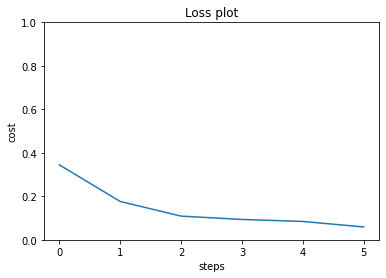

In [8]:
plt.plot(range(6), loss_vec)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.title('Loss plot')
plt.show()